# DS - 002 - Project: Comparing 3 Regression Models using **Sklearn** and **XGBoost** on a Real Estate Dataset

## Project Description:

Goal: 
- Using the `sklearn` library to create and compare a multiple linear regression and polynomial regression.
- Using the `xgboost` library to create an XGBR regression model.
- Get the Bias and Variance using the `mlxtend` library.

Dataset (Kaggle):
https://www.kaggle.com/datasets/quantbruce/real-estate-price-prediction

## 0. Preparing libraries

This environment doesn't include the `mlxtend` library, so I'm installing by myself using `pip`.

In [1]:
pip install mlxtend --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 4.9 MB/s 
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0


Importing the main libraries I'll be using for this project

In [62]:
#Importing classic libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import os 

#Importing sklearn model library
from sklearn.linear_model import SGDRegressor,LinearRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score #the last ones are for cross validation
from sklearn.preprocessing import StandardScaler #to make the feature scaling
from sklearn.preprocessing import PolynomialFeatures

import seaborn as sns #importing sns class for heatmaps
import math

#Importing Gradient Boosting Regressor
from xgboost import XGBRegressor 
import xgboost as xgb

#Importing sklearn testing library
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score, KFold, RepeatedKFold, learning_curve
from sklearn.metrics import accuracy_score, f1_score, r2_score, precision_score, recall_score, classification_report, confusion_matrix

#Importing yellowbrick to make residual plot 
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.contrib.wrapper import wrap, regressor

#Import library that will calculate bias and variance
from mlxtend.evaluate import bias_variance_decomp

## 1. Importing dataset

I'm using the `os.getcwd()` method to get the current path of the project folder.

In [63]:
#importing dataset
url_dataset = os.getcwd()+"/real_data_kaggle/realEstateDataset.csv"

df_dataset = pd.read_csv(url_dataset)

#renaming the columns of the features and output
df_dataset = df_dataset.rename({'X1 transaction date':'X1_transaction_date',
                                'X2 house age':'X2_house_age',
                                'X3 distance to the nearest MRT station':'X3_distance_nearest_MRT_station',
                                'X4 number of convenience stores':'X4_N_convenience_stores',
                                'X5 latitude':'X5_latitude','X6 longitude':'X6_longitude',
                                'Y house price of unit area':'Y_house_price_of_unit_area'},axis=1)\
                      .drop('No',axis=1)

rows, columns = df_dataset.shape

print(f"The dataset is a matrix of {columns} columns and {rows} rows")
df_dataset.head()

The dataset is a matrix of 7 columns and 414 rows


,X1_transaction_date,X2_house_age,X3_distance_nearest_MRT_station,X4_N_convenience_stores,X5_latitude,X6_longitude,Y_house_price_of_unit_area
0,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


As you see the `X1_transaction_date` column shows the data as a double, showing the month and day as the decimal part. The following method will help us to convert this date in a better format.

Special thanks to **Sohaila Diab** (https://www.kaggle.com/sohailadiab)

In [64]:
#Creating a new method to change the types of date
def to_date(data, date_column_name):
    # STEP 1: Convert transaction date to day, month and year columns
    # Create date column with `transaction date` as a date
    data['date'] = pd.to_datetime(data[date_column_name], format='%Y')

    # Create year column
    data['year'] = pd.DatetimeIndex(data['date']).year

    # Create month column by extracting the decimal part of `transaction date` and multiplying it by 12
    data['month'], data['year1'] = data[date_column_name].apply(lambda x: math.modf(x)).str
    data['month'] = data['month']*12

    # Create day column by extracting the decimal part of int
    data['day'], data['month'] = data['month'].apply(lambda x: math.modf(x)).str

    # Convert month to int
    data['month'] = (data['month']).astype(int)

    # Multiply `day` column by 30 + 1 to convert it to days
    data['day'] = (data['day']*30+1).astype(int)

    # Drop unnecessary columns
    data = data.drop([date_column_name, 'date', 'year1'], axis=1, inplace=True)

In [65]:
#Spliting the data into train and test data to make data exploration for the model
train_dataset, test_dataset = train_test_split(df_dataset,test_size=0.2,random_state=1)

print(f"The shape of the train dataset is {train_dataset.shape}")
print(f"The shape of the train dataset is {test_dataset.shape}")

The shape of the train dataset is (331, 7)
The shape of the train dataset is (83, 7)


## 2. Data Exploration

In [66]:
#Displaying general information of the dataset
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331 entries, 159 to 37
Data columns (total 7 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   X1_transaction_date              331 non-null    float64
 1   X2_house_age                     331 non-null    float64
 2   X3_distance_nearest_MRT_station  331 non-null    float64
 3   X4_N_convenience_stores          331 non-null    int64  
 4   X5_latitude                      331 non-null    float64
 5   X6_longitude                     331 non-null    float64
 6   Y_house_price_of_unit_area       331 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 20.7 KB


In [67]:
#Displaying sample of the dataset
train_dataset.head()

,X1_transaction_date,X2_house_age,X3_distance_nearest_MRT_station,X4_N_convenience_stores,X5_latitude,X6_longitude,Y_house_price_of_unit_area
159,2012.667,15.5,815.93140,4,24.97886,121.53464,37.4
95,2012.917,8.0,104.81010,5,24.96674,121.54067,51.8
11,2013.333,6.3,90.45606,9,24.97433,121.54310,58.1
374,2013.250,5.4,390.56840,5,24.97937,121.54245,49.5
165,2012.917,13.7,1236.56400,1,24.97694,121.55391,30.6


In [68]:
#Displaying general descriptive statistics report
train_dataset.describe()

,X1_transaction_date,X2_house_age,X3_distance_nearest_MRT_station,X4_N_convenience_stores,X5_latitude,X6_longitude,Y_house_price_of_unit_area
count,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000
mean,2013.169704,17.813595,1052.998068,4.205438,24.969453,121.534048,38.712991
std,0.281697,11.464981,1235.130942,2.926385,0.012370,0.015145,13.814414
min,2012.667000,0.000000,23.382840,0.000000,24.932070,121.473530,7.600000
25%,2012.917000,9.050000,289.324800,1.000000,24.963050,121.529915,28.450000
50%,2013.167000,16.200000,492.231300,5.000000,24.971100,121.539130,39.300000
75%,2013.417000,29.200000,1410.633500,6.000000,24.978440,121.543480,47.300000
max,2013.583000,42.700000,6488.021000,10.000000,25.014590,121.566270,117.500000


##### Looking graphically the relationship between the output and the features

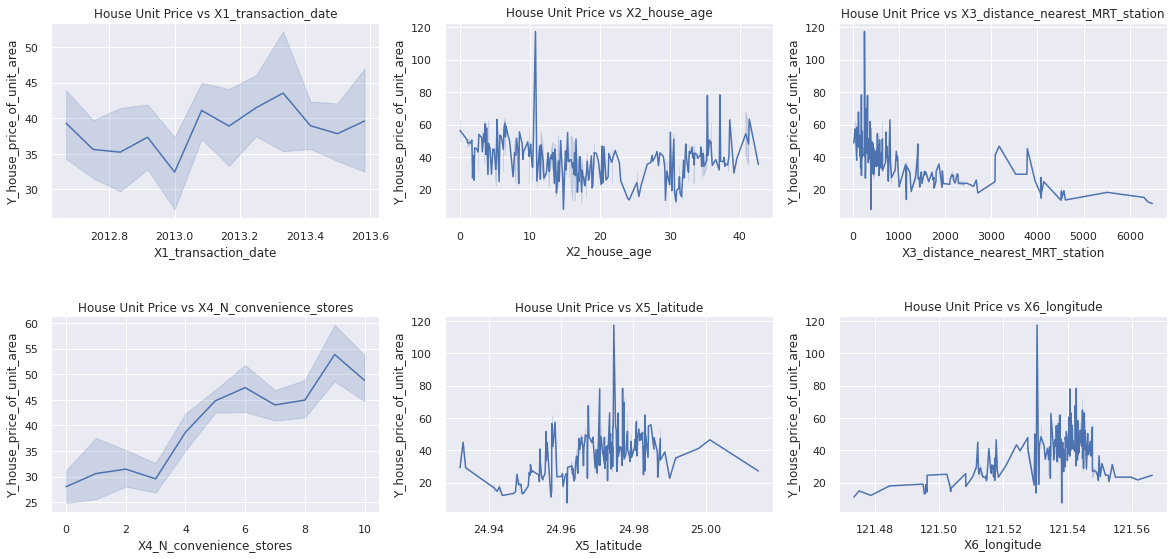

In [69]:
figure, ax = plt.subplots(2,3,figsize=(20,9))
ax = ax.flatten()

#Setting sns (seaborn)
sns.set()
for i in range(columns-1):
  sns.lineplot(data=train_dataset, x=test_dataset.columns[i],y='Y_house_price_of_unit_area',ax=ax[i])
  ax[i].set_title(f"House Unit Price vs {test_dataset.columns[i]}")

plt.subplots_adjust(hspace=0.5)
plt.show()

After looking on this, we can see some correlations (some kind of proportion) between the *house price*:
- `X4_N_convenience_stores`: when the number of stores increases, the house price increases too.
- `X3_distance_nearest_MRT_stations`: when the house is getting further away from the nearest MRT distance, its price gets lower.

##### Distribution

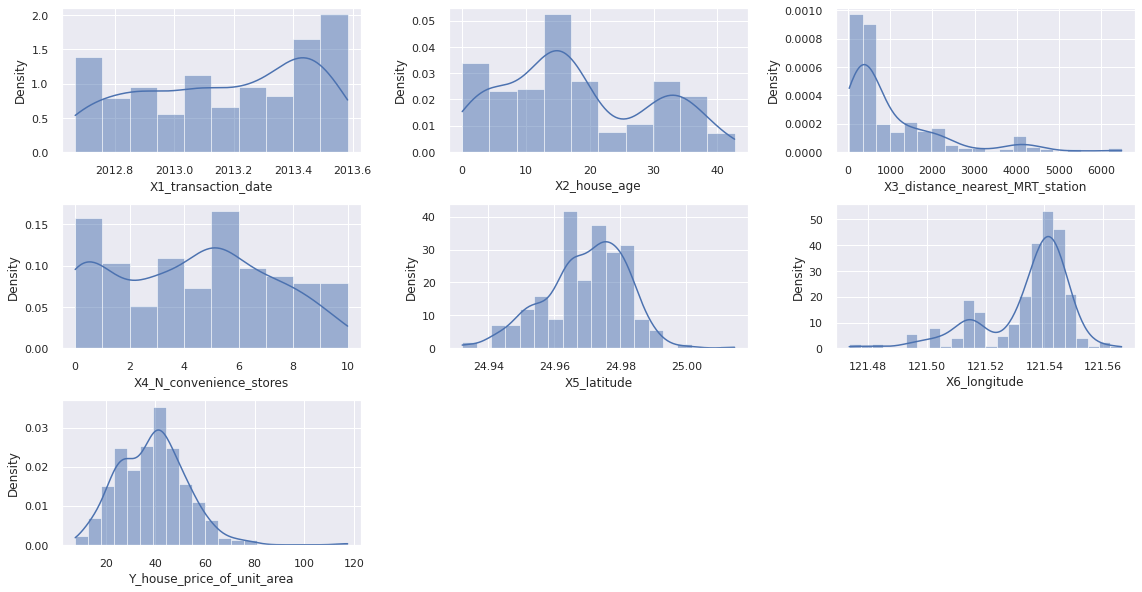

In [70]:
#Displaying the histograms for each feature
def display_histograms(train_dataset):
  figure = plt.figure(figsize=(16,16))

  #Way to create a loop and getting per each loop the index value and the column name
  for index,col in enumerate(train_dataset):
    plt.subplot(6,3,index+1)
    sns.histplot(train_dataset.loc[:,col].dropna(),kde=True, stat='density',linewidth=0.5)

  figure.tight_layout(pad=1.0)

display_histograms(train_dataset)

In the histograms, we notice some outliers in 3 variables:
- `X3_distance_nearest_MRT_station`
- `X6_longitude`
- `Y_house_price_of_unit_area`

We can see this on the Box-plots too.

Box Plots

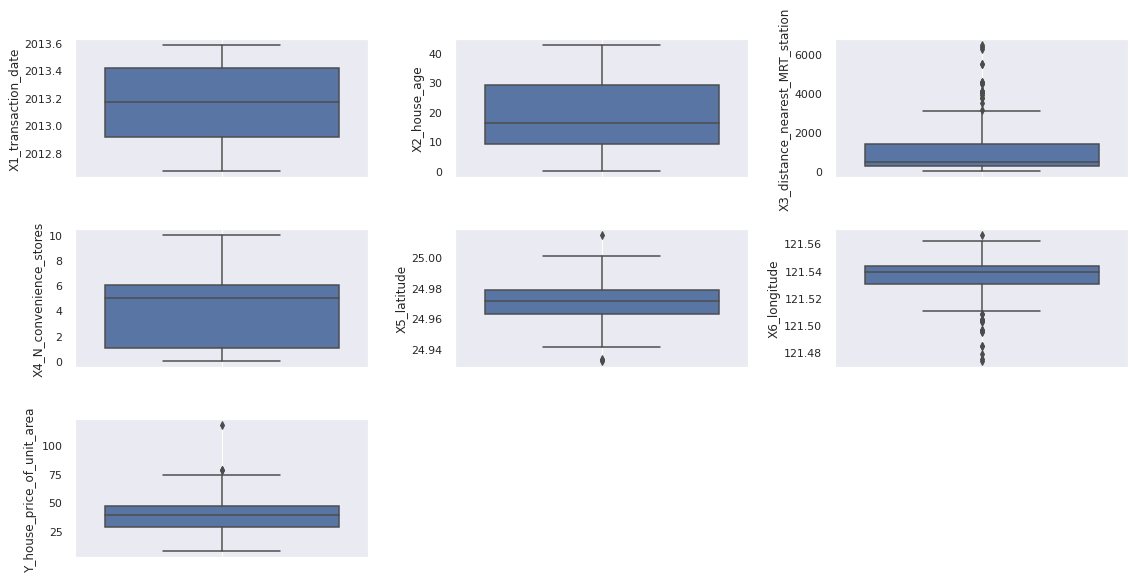

In [71]:
#Displaying the boxplot for each feature
def display_botxplots(train_dataset):
  figure = plt.figure(figsize=(16,16))

  #Way to create a loop and getting per each loop the index value and the column name
  for index,col in enumerate(train_dataset):
    plt.subplot(6,3,index+1)
    sns.boxplot(y=col, data=train_dataset.dropna())
    plt.grid()

  figure.tight_layout(pad=1.0)

display_botxplots(train_dataset)

## 3. Data Cleaning

In [72]:
# Removing outliers, based on the histograms and boxplots
train_dataset_cleaned = train_dataset[train_dataset['X3_distance_nearest_MRT_station']<3000]
train_dataset_cleaned = train_dataset_cleaned[train_dataset_cleaned['Y_house_price_of_unit_area']<80]
train_dataset_cleaned = train_dataset_cleaned[train_dataset_cleaned['X6_longitude']>121.50]

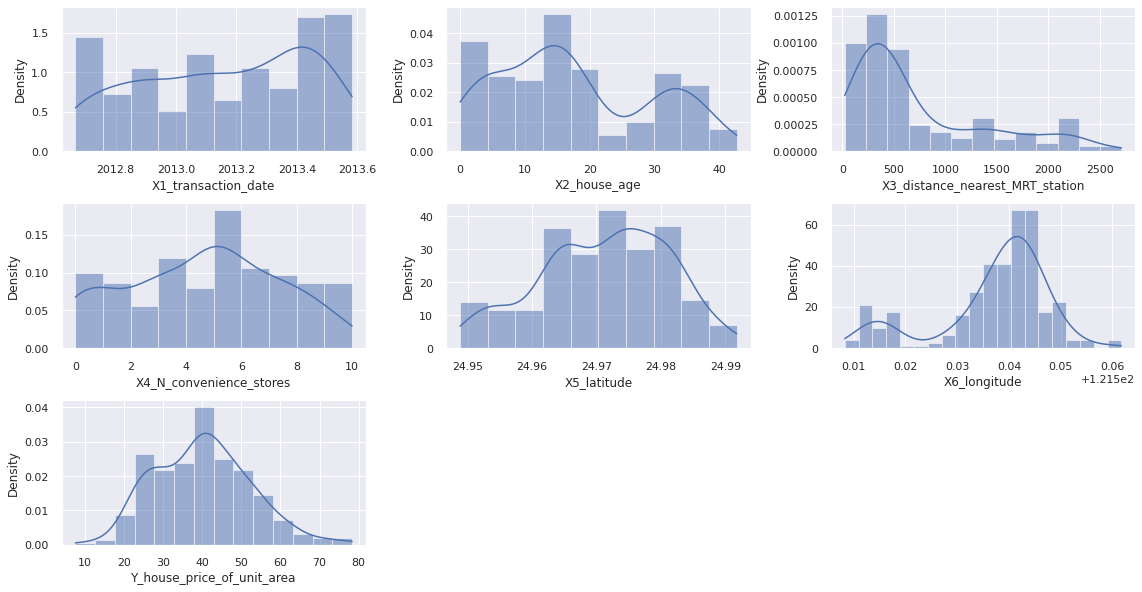

In [73]:
display_histograms(train_dataset_cleaned)

Looks a little bit better :)

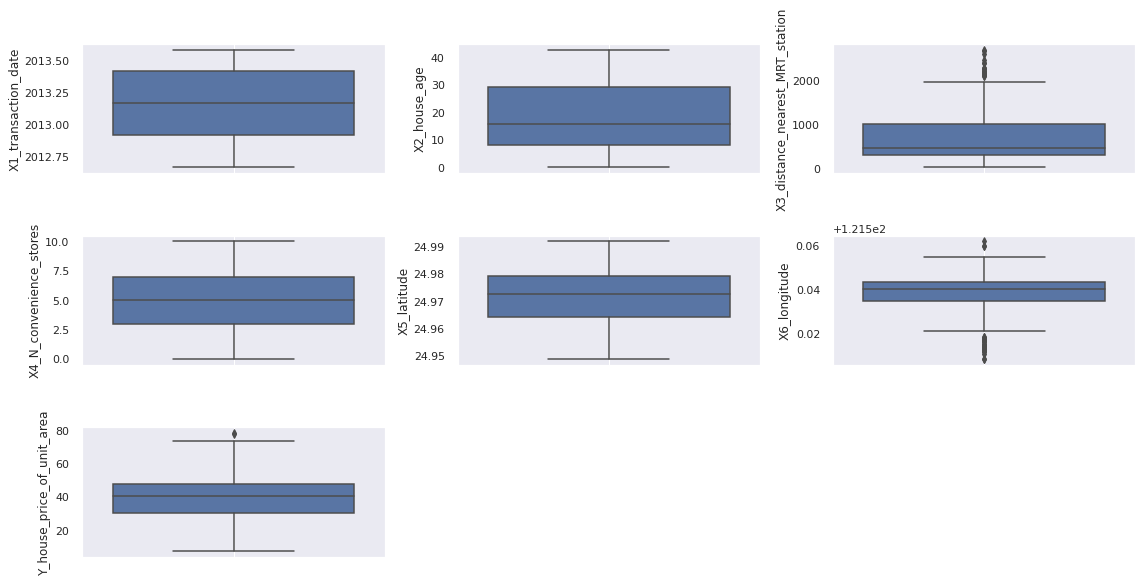

In [74]:
display_botxplots(train_dataset_cleaned)

We are going to use the transaction date so let's convert the date in a different format

In [75]:
df_train_test = pd.concat([train_dataset_cleaned,test_dataset])
to_date(df_train_test,"X1_transaction_date")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  from ipykernel import kernelapp as app


## 4. Making the Regression Model

Defining Methods for **Feature Scaling**, **Polynomial Features** and **Regresssion Execution**

In [76]:
# Method to create a new dataset with polynomial expression
def set_polynomial_features(dataset, degree_):
  
  #Create the polinomial features
  polynomial_converter = PolynomialFeatures(degree=degree_, include_bias=False)

  # Fit and transform
  poly_features = polynomial_converter.fit(dataset)
  poly_features = polynomial_converter.transform(dataset)

  return poly_features

In [77]:
# Method to create a new dataset with new scale
def set_feature_scaling(dataset):
  
  transformer = StandardScaler().fit(dataset)
  X_prep = transformer.transform(dataset)

  return X_prep

### Linear Regression

Making the splitting in train and test datasets

In [78]:
# Running the model with the current order of the columns in the dataset
X = df_train_test.drop(['Y_house_price_of_unit_area'],axis=1)
y = df_train_test['Y_house_price_of_unit_area']

X_features = ['X2_house_age','X3_distance_nearest_MRT_station','X4_N_convenience_stores','X5_latitude','X6_longitude','year','month','day']

#Feature Scaling
X_scaled = set_feature_scaling(X)

#Modeling
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X, y, test_size=0.2, random_state=1)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


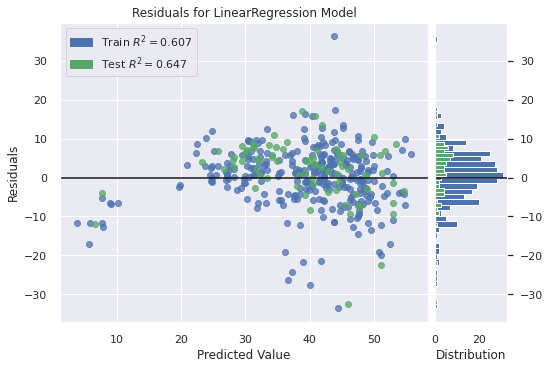

In [79]:
################################
# -------- LINEAR --------------
################################
linear_model = LinearRegression()
linear_model.fit(X_train_lr,y_train_lr)

visualizer = ResidualsPlot(linear_model,hist=True,qqplot=False)
visualizer.fit(X_train_lr, y_train_lr)
visualizer.score(X_test_lr, y_test_lr)
visualizer.show();

# Predict on train data
pred_train_lr = linear_model.predict(X_train_lr)
r2_train_lr = r2_score(y_train_lr, pred_train_lr)
mse_train_lr = mean_squared_error(y_train_lr, pred_train_lr)

# Predict on test data
pred_test_lr = linear_model.predict(X_test_lr)
r2_test_lr = r2_score(y_test_lr, pred_test_lr)
mse_test_lr = mean_squared_error(y_test_lr, pred_test_lr)

# estimate bias and variance
mse_lr, bias_lr, var_lr = bias_variance_decomp(linear_model, X_train_lr.values, y_train_lr.values, X_test_lr.values, y_test_lr.values, loss='mse', num_rounds=200, random_seed=1)


In [80]:
# summarize results
print("-----------------------")
print("       SUMMARY")
print("-----------------------")
print('MSE: %.3f' % mse_lr)
print('Bias: %.3f' % bias_lr)
print('Variance: %.3f' % var_lr)
print("R2 score (train): %.3f" % r2_train_lr)
print("R2 score (test): %.3f" % r2_test_lr)

-----------------------
       SUMMARY
-----------------------
MSE: 61.171
Bias: 59.327
Variance: 1.845
R2 score (train): 0.607
R2 score (test): 0.647


Mmm...seems that we are **underfitting** our data (high bias) and the R2 score is low. Let's create a polynomial regression model.

### **Polynomial Features**

Preparing the dataset by setting polynomial features

In [81]:
# Running the model with the current order of the columns in the dataset
X = df_train_test.drop(['Y_house_price_of_unit_area'],axis=1)
y = df_train_test['Y_house_price_of_unit_area']

X_features = ['X2_house_age','X3_distance_nearest_MRT_station','X4_N_convenience_stores','X5_latitude','X6_longitude','year','month','day']

#polynomial feature - grade 2
polynomial_feature = set_polynomial_features(X,2)

#Feature Scaling
X_scaled = set_feature_scaling(polynomial_feature)

#Modeling
X_train_po, X_test_po, y_train_po, y_test_po = train_test_split(X_scaled, y, test_size=0.3, random_state=1)

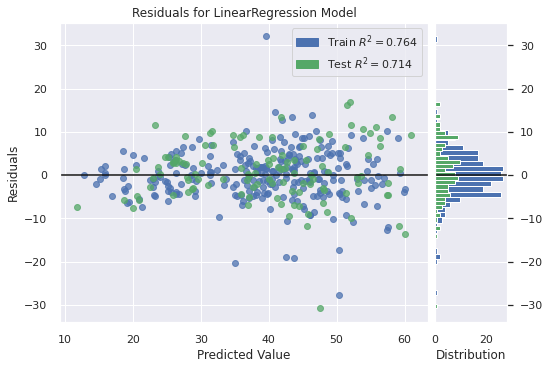

In [82]:
####################################
# -------- POLYNOMIAL --------------
####################################

linear_model_po = LinearRegression()
linear_model_po.fit(X_train_po,y_train_po)

visualizer = ResidualsPlot(linear_model_po, hist=True, qqplot=False)
visualizer.fit(X_train_po, y_train_po)
visualizer.score(X_test_po, y_test_po)
visualizer.show();

# Predict on train data
pred_train_po = linear_model_po.predict(X_train_po)
r2_train_po = r2_score(y_train_po, pred_train_po)
mse_train_po = mean_squared_error(y_train_po, pred_train_po)

# Predict on test data
pred_test_po = linear_model_po.predict(X_test_po)
r2_test_po = r2_score(y_test_po, pred_test_po)
mse_test_po = mean_squared_error(y_test_po, pred_test_po)

# estimate bias and variance
mse_po, bias_po, var_po = bias_variance_decomp(linear_model_po, X_train_po, y_train_po.values, X_test_po, y_test_po.values, loss='mse', num_rounds=200, random_seed=1)


In [83]:
# summarize results
print("-----------------------")
print("       SUMMARY")
print("-----------------------")
print('MSE: %.3f' % mse_po)
print('Bias: %.3f' % bias_po)
print('Variance: %.3f' % var_po)
print("R2 score (train): %.3f" % r2_train_po)
print("R2 score (test): %.3f" % r2_test_po)

-----------------------
       SUMMARY
-----------------------
MSE: 57.526
Bias: 48.061
Variance: 9.465
R2 score (train): 0.764
R2 score (test): 0.714


Even though we still have a high bias, the variance is increasing and the R2 score increased too. Let's try with another algorithm, in this case, the **XGBoost Regressor**.

### **XGBRegressor**

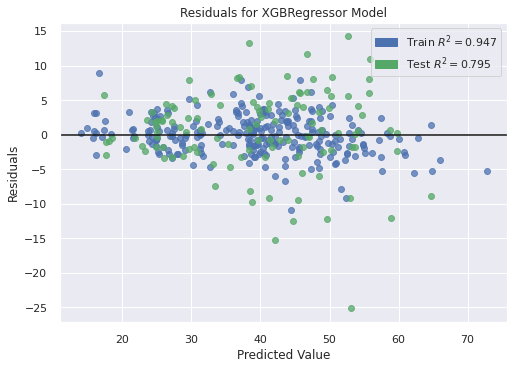

In [84]:
###############################
# -------- XGBR MODEL ---------
###############################

X_train_po_xgbr = X_train_po
X_test_po_xgbr = X_test_po
y_train_po_xgbr = y_train_po
y_test_po_xgbr = y_test_po

xgbr_model_pol = XGBRegressor(objective ='reg:squarederror', n_estimators = 100, seed = 0, max_depth = 3)
xgbr_model_pol.fit(X_train_po_xgbr,y_train_po_xgbr)

visualizer = ResidualsPlot(xgbr_model_pol, hist=False, qqplot=False)
visualizer.fit(X_train_po_xgbr, y_train_po_xgbr)
visualizer.score(X_test_po_xgbr, y_test_po_xgbr)
visualizer.show();

# Predict on train data
pred_train_po_xgbr = xgbr_model_pol.predict(X_train_po_xgbr)
r2_train_po_xgbr = r2_score(y_train_po_xgbr, pred_train_po_xgbr)
mse_train_po_xgbr = mean_squared_error(y_train_po_xgbr, pred_train_po_xgbr)

# Predict on test data
pred_test_po_xgbr = xgbr_model_pol.predict(X_test_po_xgbr)
r2_test_po_xgbr = r2_score(y_test_po_xgbr, pred_test_po_xgbr)
mse_test_po_xgbr = mean_squared_error(y_test_po_xgbr, pred_test_po_xgbr)

# estimate bias and variance
mse_po_xgbr, bias_po_xgbr, var_po_xgbr = bias_variance_decomp(xgbr_model_pol, X_train_po_xgbr, y_train_po_xgbr.values, X_test_po_xgbr, y_test_po_xgbr.values, loss='mse', num_rounds=200, random_seed=1)

In [85]:
# summarize results
print("-----------------------")
print("       SUMMARY")
print("-----------------------")
print('MSE: %.3f' % mse_po_xgbr)
print('Bias: %.3f' % bias_po_xgbr)
print('Variance: %.3f' % var_po_xgbr)
print("R2 score (train): %.3f" % r2_train_po_xgbr)
print("R2 score (test): %.3f" % r2_test_po_xgbr)

-----------------------
       SUMMARY
-----------------------
MSE: 40.861
Bias: 32.761
Variance: 8.100
R2 score (train): 0.947
R2 score (test): 0.795


Much better :). Although we can expect to improve our model, but that's enough for now. It would be better if we can have more data to train our model but I'm facing with the current dataset jeje.

**HAPPY LEARNING!**